# Sentiment Analysis of IMDB Movie Ratings - ENGO 680 Final Project
### By Adam Smith

**To run only the final fully-connected model which satisfies the accuracy requirements and bypass the other two models, run the cell containing the imports, and then all cells below the section labelled *Fully-Connected Model*.  The downloads and preprocessing for the other models takes a few minutes to run.**

In [1]:
# Uncomment this code block if running in Google Colab
# This will download the required libraries and data files

'''
!pip install multiprocess
!wget -nc https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!wget -nc https://nlp.stanford.edu/data/glove.6B.zip
!tar -xf aclImdb_v1.tar.gz
!unzip -n glove.6B.zip -d glove

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
'''

"\n!pip install multiprocess\n!wget -nc https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz\n!wget -nc https://nlp.stanford.edu/data/glove.6B.zip\n!tar -xf aclImdb_v1.tar.gz\n!unzip -n glove.6B.zip -d glove\n\nimport nltk\nnltk.download('stopwords')\nnltk.download('punkt')\nnltk.download('wordnet')\nnltk.download('omw-1.4')\n"

In [2]:
import re
import glob
import random
from itertools import chain
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from multiprocess import Pool
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, matthews_corrcoef
from tensorflow.keras.layers import ( 
    TextVectorization,
    Embedding,
    Dense,
    Dropout,
    Conv1D,
    MaxPool1D,
    GlobalMaxPooling1D
)
from tensorflow.keras import Sequential
from tensorflow.keras.datasets import imdb
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.initializers import Constant
from tensorflow.keras.losses import BinaryCrossentropy

## Part I: Data Processing 

First, we define a Dataset class to load and process the data.

In [3]:
class Dataset():
    # Class to represent and process the data
    
    def __init__(self):
        
        # Define and load file names
        train_files = glob.glob('./aclImdb/train/???/*.txt')
        test_files = glob.glob('./aclImdb/test/???/*.txt')
        
        # Read the training data into lists
        self.train_data, self.train_labels = [], []
        for file in train_files:
            with open(file, 'r') as f:
                self.train_data.append(f.read())
                label = file[-5] if file[-6] == '_' else file[-6:-4]
                self.train_labels.append(int(label))
        
        # Read the testing data into lists
        self.test_data, self.test_labels = [], []
        for file in test_files:
            with open(file, 'r') as f:
                self.test_data.append(f.read())
                label = file[-5] if file[-6] == '_' else file[-6:-4]
                self.test_labels.append(int(label))
    
    
    def process(self, use_multiprocessing=False, num_processes=8, reduce_test=True, shuffle=True, random_state=42):
        # Process the reviews
        if use_multiprocessing:
            # Batch the data so we can process batches concurrently
            subset_length = len(self.train_data) // num_processes
            batched_train_data, batched_test_data = [], []
            for i in range(num_processes - 1):
                batched_train_data.append(self.train_data[i * subset_length:(i + 1) * subset_length])
                batched_test_data.append(self.test_data[i * subset_length:(i + 1) * subset_length])
            batched_train_data.append(self.train_data[(num_processes - 1) * subset_length:])
            batched_test_data.append(self.test_data[(num_processes - 1) * subset_length:])
            
            # Process batches concurrently
            with Pool(num_processes) as pool:
                batched_train_data = pool.map(self.preprocess_text, batched_train_data)            
                batched_test_data = pool.map(self.preprocess_text, batched_test_data)
            
            # Merge the results back together
            self.train_data = list(chain(*batched_train_data))
            self.test_data = list(chain(*batched_test_data))
                            
        else:
            self.train_data = self.preprocess_text(self.train_data)
            self.test_data = self.preprocess_text(self.test_data)
        
        if reduce_test:
            self.reduce_test_set()
        
        # Map the low ratings to 0 and the high ratings to 1
        self.train_labels = list(map(lambda x: 1 if x > 5 else 0, self.train_labels))
        self.test_labels = list(map(lambda x: 1 if x > 5 else 0, self.test_labels))
        
        if shuffle:            
            if random_state:
                random.seed(random_state)
            
            # Shuffle training data
            train_data_label_pairs = list(zip(self.train_data, self.train_labels))
            random.shuffle(train_data_label_pairs)
            self.train_data, self.train_labels = zip(*train_data_label_pairs)
            
            # Shuffle test data
            # Order of the test data is not important, so we actually don't need to shuffle here
            # test_data_label_pairs = list(zip(self.test_data, self.test_labels))
            # random.shuffle(test_data_label_pairs)
            # self.test_data, self.test_labels = zip(*test_data_label_pairs)
        
        # Convert to numpy arrays
        self.train_data, self.train_labels = np.array(self.train_data), np.array(self.train_labels)
        self.test_data, self.test_labels = np.array(self.test_data), np.array(self.test_labels)
    
    
    def preprocess_text(self, data):
        # Pre-compile regex patterns
        html_regex = re.compile(r'<.*?>')
        punctuation_regex = re.compile(r'[^a-zA-Z0-9]')
        
        # Stop words to exclude from the data
        stop_words = set(stopwords.words('english'))
        
        # Define the lemmatizer
        lemmatizer = WordNetLemmatizer()
        
        processed_data = []
        for review in data:                    
            # Remove HTML tags
            review = html_regex.sub('', review)
            
            # Remove punctuation
            review = punctuation_regex.sub(' ', review).lower()
            
            # Tokenize
            review = word_tokenize(review)
            
            # Remove stop words
            review = filter(lambda w: w not in stop_words, review)
            
            # Lemmatize
            review = ' '.join(lemmatizer.lemmatize(word, self.get_part_of_speech(word)) for word in review)
            processed_data.append(review)
        return processed_data
    
    
    @staticmethod
    def get_part_of_speech(word):
        # Get the most probable part of speech for a given word
        # Returns 'n' for noun, 'v' for verb, 'r' for adverb, 'a' for adjective, or 's' for satellite adjectives
        # If the pos is unknown, return 'n'
        
        pos_counter = Counter(syn.pos() for syn in wordnet.synsets(word))
        return max(pos_counter) if pos_counter else 'n'
    
    
    def reduce_test_set(self):
        # Remove words from the test set which do not appear in the training set
        all_train_words = set(chain(*(s.split(' ') for s in self.train_data)))
        self.test_data = (review.split(' ') for review in self.test_data)
        self.test_data = [' '.join(filter(lambda w: w in all_train_words, review)) for review in self.test_data]

Calling the `process` method takes a bit of time, but we can speed it up a bit with multiprocessing.  The python standard library `multiprocessing` module often has bugs in IPython, so we must use the [multiprocess](https://pypi.org/project/multiprocess/) module, which is equivalent but serializes with dill instead of pickle.

The `reduce_test` argument reduces the test set to only contain words which are present in the training data.

In [4]:
# Check if the notebook is running in Google Colab by trying to import google.colab
try: 
    import google.colab
    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False

data = Dataset()
# If we're in Colab, don't use multiprocessing
if IN_COLAB:
    data.process(use_multiprocessing=False, reduce_test=True)  # This may take a while (~4 mins on GC) (sorry)
else:
    data.process(use_multiprocessing=True, num_processes=8, reduce_test=True)  # Much faster, but multiprocessing doesn't seem to play well with GC

## Part II: Models

### Bayesian Network

We first define a simple Baysesian Network as a baseline.  We vectorize the data with the `sklearn`'s `CountVectorizer` class, which returns a sparse matrix representation of the data.  Each row corresponds to a vector with length the size of the vocabulary, with each entry corresponding to the number of times the corresponding word occurs in the review.

In [5]:
vectorizer = CountVectorizer(dtype=np.uint8)
train_counts = vectorizer.fit_transform(data.train_data)
test_counts = vectorizer.transform(data.test_data)

In [6]:
bayesian_network = MultinomialNB()
bayesian_network.fit(train_counts, data.train_labels)

MultinomialNB()

In [7]:
bayes_train_acc = bayesian_network.score(train_counts, data.train_labels)
print(f'Naive Bayesian train accuracy {bayes_train_acc:.2%}')

Naive Bayesian train accuracy 90.27%


In [8]:
bayes_test_acc = bayesian_network.score(test_counts, data.test_labels)
print(f'Naive Bayesian test accuracy {bayes_test_acc:.2%}')

Naive Bayesian test accuracy 81.98%


The naive Bayesian model performs decently on the training data, but fails to classify the test data as well.  We'll compute the MCC coefficient for a better analysis of the performance.

In [9]:
train_preds = bayesian_network.predict(train_counts)
test_preds = bayesian_network.predict(test_counts)
print(f'Bayesian network train set MCC: {matthews_corrcoef(data.train_labels, train_preds):.3f}')
print(f'Bayesian network test set MCC: {matthews_corrcoef(data.test_labels, test_preds):.3f}')

Bayesian network train set MCC: 0.806
Bayesian network test set MCC: 0.644


### Convolutional Model

Now we will try a deep learning model.

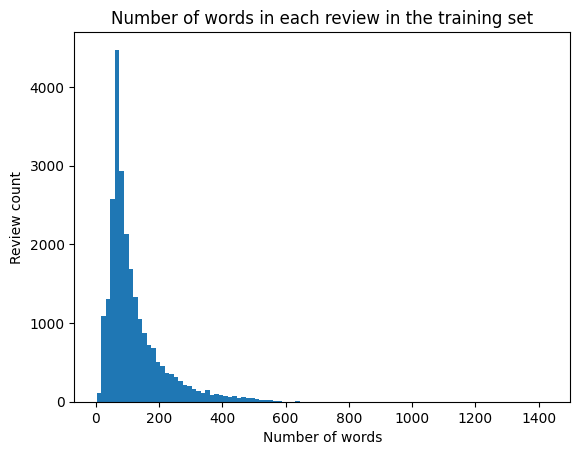

In [10]:
review_lens = [len(review.split(' ')) for review in data.train_data]
plt.hist(review_lens, bins=100)
plt.xlabel('Number of words')
plt.ylabel('Review count')
plt.title('Number of words in each review in the training set')
# plt.savefig('./img/num_words.png', dpi=300)
plt.show()

In [11]:
num_unique_train_words = len(set(chain(*(s.split(' ') for s in data.train_data))))

# Define hyperparameters
VOCAB_SIZE = num_unique_train_words
SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 100  # one of 50, 100, 200, or 300
BATCH_SIZE = 256
EPOCHS = 5
LR=1e-3

The `TextVectorization` layer maps the strings to integer sequences.

In [12]:
vectorizer = TextVectorization(
    standardize=None,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)
vectorizer.adapt(data.train_data)

2022-12-14 11:04:31.851206: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-14 11:04:31.851823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-14 11:04:32.044777: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-14 11:04:32.106220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1 Pro


For the embeddings, we will employ the pretrained [GloVe](https://nlp.stanford.edu/projects/glove/) word embeddings. 

In [13]:
path_to_glove_file = f'./glove/glove.6B.{EMBEDDING_DIM}d.txt'

embeddings_index = {}
with open(path_to_glove_file, 'r') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, sep=' ')
        embeddings_index[word] = coefs

In [14]:
vocab = vectorizer.get_vocabulary()

# Dictionary mapping each word in the vocabulary to its index
word_index = {word: i for i, word in enumerate(vocab)} 

# Prepare the embedding matrix
embedding_matrix = np.zeros((num_unique_train_words, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Now we define, compile, and fit the model.

In [15]:
data_format = 'channels_last'

model = Sequential([
    vectorizer,
    Embedding(
        VOCAB_SIZE, 
        EMBEDDING_DIM,
        embeddings_initializer=Constant(embedding_matrix),
        trainable=False
    ),
    Conv1D(128, 7, activation='relu', data_format=data_format),
    MaxPool1D(5, data_format=data_format),
    Conv1D(128, 5, activation='relu', data_format=data_format),
    MaxPool1D(5, data_format=data_format),
    Conv1D(128, 5, activation='relu', data_format=data_format),
    GlobalMaxPooling1D(data_format=data_format),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 300)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 300, 100)          5902200   
                                                                 
 conv1d (Conv1D)             (None, 294, 128)          89728     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 58, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 54, 128)           82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 10, 128)          0

In [17]:
model.compile(optimizer=Adam(learning_rate=LR),
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
history = model.fit(
    data.train_data, 
    data.train_labels, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_data=(data.test_data, data.test_labels)
)

Epoch 1/5


2022-12-14 11:04:37.691625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 0.6064 - accuracy: 0.6171

2022-12-14 11:04:42.938375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 7s 58ms/step - loss: 0.6064 - accuracy: 0.6171 - val_loss: 0.4736 - val_accuracy: 0.7314
Epoch 2/5
98/98 [==============================] - 5s 51ms/step - loss: 0.4377 - accuracy: 0.7914 - val_loss: 0.4565 - val_accuracy: 0.7449
Epoch 3/5
98/98 [==============================] - 5s 51ms/step - loss: 0.3835 - accuracy: 0.8228 - val_loss: 0.3644 - val_accuracy: 0.8233
Epoch 4/5
98/98 [==============================] - 5s 51ms/step - loss: 0.3154 - accuracy: 0.8656 - val_loss: 0.3448 - val_accuracy: 0.8518
Epoch 5/5
98/98 [==============================] - 5s 52ms/step - loss: 0.2678 - accuracy: 0.8925 - val_loss: 0.3331 - val_accuracy: 0.8515


Note that the training accuracy shown above is inaccurate due to the existance of the dropout layer in the model and the fact that this is computed using averages of batch accuracies.  We compute the true training accuracy below.

In [19]:
# Compute the true training accuracy
train_preds = np.where(model.predict(data.train_data) > 0.5, 1, 0).flatten()
train_acc = (train_preds == data.train_labels).sum()/len(data.train_labels)
print(f'True training accuracy: {train_acc:.2%}')

 25/782 [..............................] - ETA: 3s

2022-12-14 11:05:05.025177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 6s 7ms/step
True training accuracy: 94.26%


Text(0.5, 1.0, 'Accuracies during training')

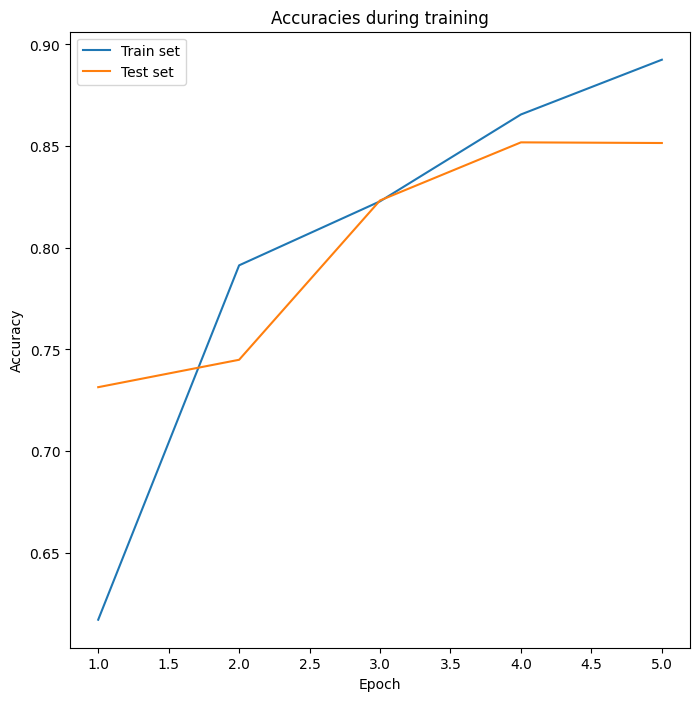

In [20]:
plt.figure(figsize=(8, 8))
plt.plot(range(1, EPOCHS + 1), history.history['accuracy'], label='Train set')
plt.plot(range(1, EPOCHS + 1), history.history['val_accuracy'], label='Test set')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Accuracies during training')
# plt.savefig('./img/conv_acc.png', dpi=300)

In [21]:
test_preds = np.where(model.predict(data.test_data) > 0.5, 1, 0).flatten()
print(f'Convolutional model train set MCC: {matthews_corrcoef(data.train_labels, train_preds):.3f}')
print(f'Convolutional model test set MCC: {matthews_corrcoef(data.test_labels, test_preds):.3f}')

782/782 [==============================] - 5s 7ms/step
Convolutional model train set MCC: 0.886
Convolutional model test set MCC: 0.705


In [22]:
# Free up memory so we don't exceed Google Colab's memory limits
if IN_COLAB:
    del train_counts
    del test_counts
    del data
    del embedding_matrix
    del embeddings_index
    del vocab
    del history
    del model

This model performs okay but fails to get the testing accuracy over ~85% while limiting overfitting.  To ensure I satisfy the assignment requirements, I will define another model using the preprocessed data from keras and the suggested vectorization.

### Fully-Connected Model

In [23]:
# Hyperparameters
VOCAB_SIZE = 10000
LR = 2e-4
EPOCHS = 3
BATCH_SIZE = 256
L2_COEFF = 0.002

In [24]:
# Load the data
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=VOCAB_SIZE)

def vectorize(sequences, dim):
    result = np.zeros((len(sequences), dim))
    for i, seq in enumerate(sequences):
        result[i, seq] = 1
    return result

# Vectorize the data
train_data = vectorize(train_data, VOCAB_SIZE)
test_data = vectorize(test_data, VOCAB_SIZE)

In [25]:
# Define a simple fully-connected network
model_fc = Sequential([
    Dense(32, activation='relu', input_shape=(VOCAB_SIZE,), kernel_regularizer=L2(L2_COEFF)),
    Dropout(0.5),
    Dense(16, activation='relu', kernel_regularizer=L2(L2_COEFF)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [26]:
model_fc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                320032    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,577
Trainable params: 320,577
Non-trainable params: 0
_________________________________________________________________


In [27]:
model_fc.compile(
    optimizer=Adam(learning_rate=LR),
    loss=BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model_fc.fit(
    train_data, 
    train_labels, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(test_data, test_labels)
)

Epoch 1/3


2022-12-14 11:05:21.472034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 0.7846 - accuracy: 0.6164

2022-12-14 11:05:24.903959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 5s 42ms/step - loss: 0.7846 - accuracy: 0.6164 - val_loss: 0.6794 - val_accuracy: 0.8180
Epoch 2/3
98/98 [==============================] - 2s 20ms/step - loss: 0.6357 - accuracy: 0.7608 - val_loss: 0.5469 - val_accuracy: 0.8610
Epoch 3/3
98/98 [==============================] - 2s 18ms/step - loss: 0.5369 - accuracy: 0.8190 - val_loss: 0.4651 - val_accuracy: 0.8769


Keep in mind here that the above training accuracy is not accurate for the same reasons as before.

## Part III: Testing and Results
Here, we will take a closer look at the performance of the second deep learning model.

In [29]:
# Get Predictions
train_preds = model_fc.predict(train_data)
test_preds = model_fc.predict(test_data)
train_preds = np.where(train_preds.flatten() > 0.5, 1, 0)
test_preds = np.where(test_preds.flatten() > 0.5, 1, 0)

 47/782 [>.............................] - ETA: 2s

2022-12-14 11:05:31.170857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 2s 2ms/step


In [30]:
# Compute accuracies
train_accuracy = (train_preds == train_labels).sum()/len(train_labels)
test_accuracy = (test_preds == test_labels).sum()/len(test_labels)

print(f'Training Accuracy: {train_accuracy:.2%}')
print(f'Testing Accuracy: {test_accuracy:.2%}')

Training Accuracy: 90.21%
Testing Accuracy: 87.69%


This model satisfies the assignment requirements of at least 87% accuracy and low overfitting (at least most of the time).  I was not able to increase the testing accuracy above this without overfitting the model.

Text(0.5, 1.0, 'Accuracies during training')

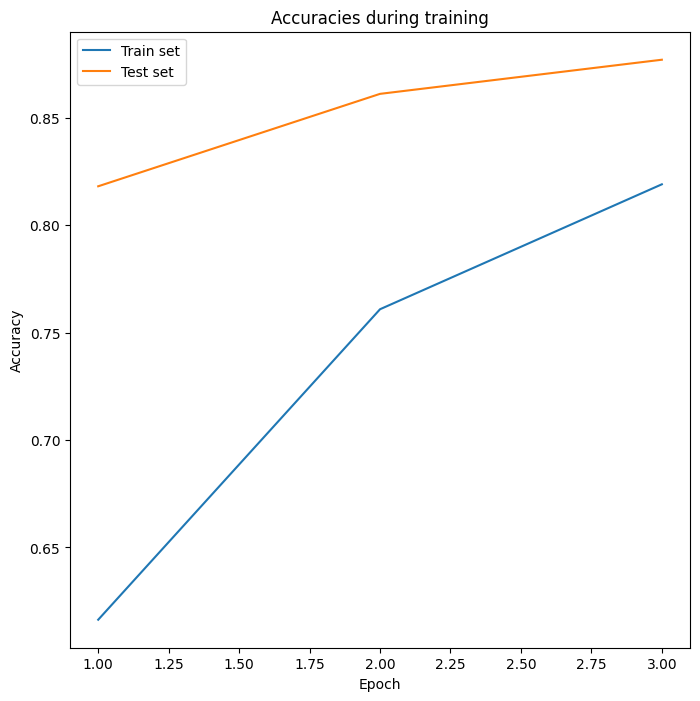

In [31]:
plt.figure(figsize=(8, 8))
plt.plot(range(1, EPOCHS + 1), history.history['accuracy'], label='Train set')
plt.plot(range(1, EPOCHS + 1), history.history['val_accuracy'], label='Test set')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Accuracies during training')
# plt.savefig('./img/fc_acc.png', dpi=300)

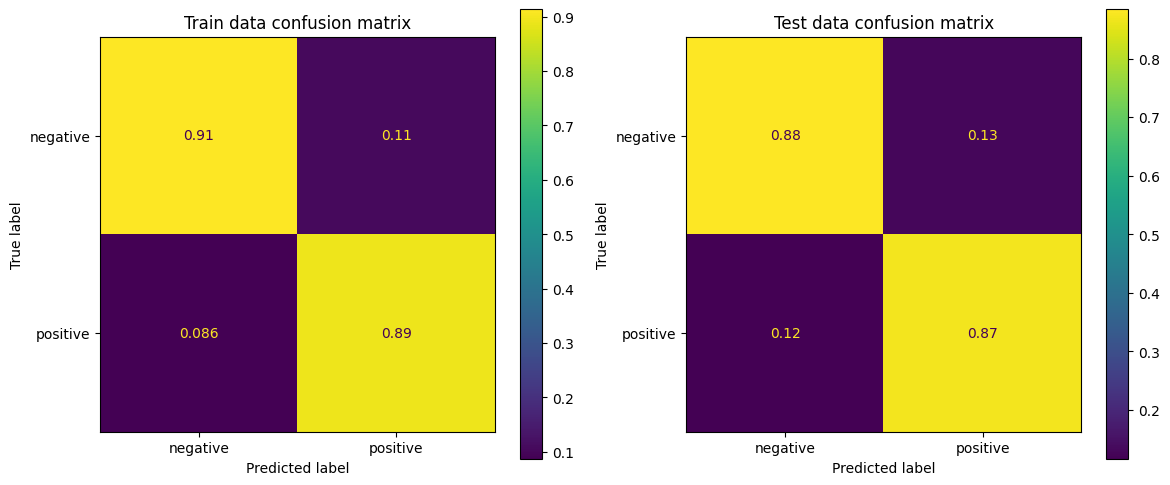

In [32]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
ax = plt.gca()
ConfusionMatrixDisplay.from_predictions(
    train_labels, 
    train_preds, 
    normalize='pred', 
    display_labels=['negative', 'positive'],
    ax=ax
)
plt.title('Train data confusion matrix')

plt.subplot(1, 2, 2)
ax = plt.gca()
ConfusionMatrixDisplay.from_predictions(
    test_labels, 
    test_preds, 
    normalize='pred', 
    display_labels=['negative', 'positive'],
    ax=ax
)
plt.title('Test data confusion matrix')
plt.tight_layout()
# plt.savefig('./img/fc_confusion.png', dpi=300)

As seen in the confusion matrices above, it seems the model mistakenly classifies negative reviews roughly as often as positive reviews.

In [33]:
print(f'Train set MCC score: {matthews_corrcoef(train_labels, train_preds):.3f}')
print(f'Test set MCC score: {matthews_corrcoef(test_labels, test_preds):.3f}')

Train set MCC score: 0.805
Test set MCC score: 0.754


The above MCC scores reaffirm the good, but not great, performance of the model.